Dataset: MNIST: http://yann.lecun.com/exdb/mnist/

Training: 60,000
Testing: 10,000

Problem: Classify handwritten digits (0-9) using the MNIST dataset. This is a classification problem where each image is labeled with a digit.

Dataset Source:
http://yann.lecun.com/exdb/mnist/

Dataset Overview:

70,000 images (60,000 for training, 10,000 for testing)
28×28 grayscale images
10 digit classes (0-9)
Complexity:
Large dataset (70,000 samples)
784 features per image (28×28 pixels)
High variability in handwriting styles

# Part 1

In [1]:
import numpy as np
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim):
        """Initialize the network and its parameters."""
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.parameters = self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights with a small random value and biases with zeros."""
        np.random.seed(42)
        params = {
            'W1': np.random.randn(self.hidden_dim, self.input_dim) * 0.01,
            'b1': np.zeros((self.hidden_dim, 1)),
            'W2': np.random.randn(self.output_dim, self.hidden_dim) * 0.01,
            'b2': np.zeros((self.output_dim, 1))
        }
        return params

    def _relu(self, z):
        """ReLU activation function."""
        return np.maximum(0, z)

    def _softmax(self, z):
        """Softmax activation function for multiclass classification."""
        exp_values = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_values / np.sum(exp_values, axis=0, keepdims=True)

    def forward(self, X):
        """
        Perform forward propagation.
        Returns the output probabilities and caches intermediate values.
        """
        W1, b1 = self.parameters['W1'], self.parameters['b1']
        W2, b2 = self.parameters['W2'], self.parameters['b2']

        z1 = np.dot(W1, X) + b1
        a1 = self._relu(z1)
        z2 = np.dot(W2, a1) + b2
        a2 = self._softmax(z2)

        # Cache intermediate variables for backpropagation
        self.cache = {'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}
        return a2

    def compute_cost(self, predictions, Y):
        """Compute cross-entropy loss."""
        m = Y.shape[1]
        # Added a small epsilon for numerical stability
        cost = -np.sum(Y * np.log(predictions + 1e-8)) / m
        return np.squeeze(cost)

    def _relu_derivative(self, z):
        """Compute derivative of the ReLU function."""
        return (z > 0).astype(float)

    def backward(self, X, Y):
        """
        Perform backward propagation to compute gradients.
        """
        m = X.shape[1]
        W2 = self.parameters['W2']
        z1, a1, a2 = self.cache['z1'], self.cache['a1'], self.cache['a2']

        dz2 = a2 - Y  # derivative for softmax with cross-entropy
        dW2 = np.dot(dz2, a1.T) / m
        db2 = np.sum(dz2, axis=1, keepdims=True) / m

        dz1 = np.dot(W2.T, dz2) * self._relu_derivative(z1)
        dW1 = np.dot(dz1, X.T) / m
        db1 = np.sum(dz1, axis=1, keepdims=True) / m

        self.gradients = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

    def update_parameters(self, learning_rate):
        """Update network parameters using computed gradients."""
        for key in self.parameters:
            self.parameters[key] -= learning_rate * self.gradients['d' + key]

    def predict(self, X):
        """Return the predicted classes for input X."""
        output = self.forward(X)
        return np.argmax(output, axis=0)

    def train(self, X, Y, iterations=1000, learning_rate=0.01, verbose=False):
        """
        Train the neural network using traditional gradient descent.
        """
        for i in range(iterations):
            probs = self.forward(X)
            cost = self.compute_cost(probs, Y)
            self.backward(X, Y)
            self.update_parameters(learning_rate)
            if verbose and i % 100 == 0:
                print(f"Iteration {i}: cost = {cost:.4f}")

    def train_minibatch(self, X, Y, batch_size=32, iterations=1000, learning_rate=0.01, verbose=False):
        """
        Train the neural network using minibatch gradient descent.
        """
        m = X.shape[1]
        for i in range(iterations):
            # Shuffle the training data each iteration
            indices = np.random.permutation(m)
            X_shuffled = X[:, indices]
            Y_shuffled = Y[:, indices]

            for j in range(0, m, batch_size):
                X_batch = X_shuffled[:, j:j+batch_size]
                Y_batch = Y_shuffled[:, j:j+batch_size]

                probs = self.forward(X_batch)
                self.backward(X_batch, Y_batch)
                self.update_parameters(learning_rate)
            if verbose and i % 100 == 0:
                batch_cost = self.compute_cost(probs, Y_batch)
                print(f"Minibatch Iteration {i}: cost = {batch_cost:.4f}")


In [2]:
# ------------------------- Data Preparation and Testing -------------------------

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
# Normalize the pixel values to [0, 1]
X_train = X_train / 255.0
X_test  = X_test  / 255.0

# Flatten images: each column is one flattened image
X_train_flat = X_train.reshape(X_train.shape[0], -1).T  # shape: (784, number of examples)
X_test_flat  = X_test.reshape(X_test.shape[0], -1).T

# One-hot encode the labels and transpose so that each column is one label vector
Y_train = to_categorical(y_train, num_classes=10).T
Y_test  = to_categorical(y_test, num_classes=10).T

# Hyperparameters
input_dim  = X_train_flat.shape[0]  # 784
hidden_dim = 128
output_dim = 10


In [6]:
# -------------------- Training using Traditional Gradient Descent --------------------
print("Training with traditional gradient descent:")
nn_gd = NeuralNetwork(input_dim, hidden_dim, output_dim)
start_time = time.time()
nn_gd.train(X_train_flat, Y_train, iterations=2000, learning_rate=0.01, verbose=True)
print(f"Traditional GD training time: {time.time() - start_time:.2f} seconds")

# Evaluate on test set
predictions = nn_gd.predict(X_test_flat)
accuracy = np.mean(predictions == np.argmax(Y_test, axis=0)) * 100
print(f"Test Accuracy (Traditional GD): {accuracy:.2f}%\n")

# -------------------- Training using Minibatch Gradient Descent --------------------
print("Training with minibatch gradient descent:")
nn_mb = NeuralNetwork(input_dim, hidden_dim, output_dim)
start_time = time.time()
nn_mb.train_minibatch(X_train_flat, Y_train, batch_size=256, iterations=2000, learning_rate=0.01, verbose=True)
print(f"Minibatch GD training time: {time.time() - start_time:.2f} seconds")

# Evaluate on test set
predictions = nn_mb.predict(X_test_flat)
accuracy = np.mean(predictions == np.argmax(Y_test, axis=0)) * 100
print(f"Test Accuracy (Minibatch GD): {accuracy:.2f}%")

Training with traditional gradient descent:
Iteration 0: cost = 2.3028
Iteration 100: cost = 2.2905
Iteration 200: cost = 2.2682
Iteration 300: cost = 2.2213
Iteration 400: cost = 2.1266
Iteration 500: cost = 1.9597
Iteration 600: cost = 1.7192
Iteration 700: cost = 1.4532
Iteration 800: cost = 1.2258
Iteration 900: cost = 1.0547
Iteration 1000: cost = 0.9285
Iteration 1100: cost = 0.8335
Iteration 1200: cost = 0.7603
Iteration 1300: cost = 0.7026
Iteration 1400: cost = 0.6562
Iteration 1500: cost = 0.6181
Iteration 1600: cost = 0.5865
Iteration 1700: cost = 0.5599
Iteration 1800: cost = 0.5371
Iteration 1900: cost = 0.5175
Traditional GD training time: 2530.47 seconds
Test Accuracy (Traditional GD): 87.56%

Training with minibatch gradient descent:
Minibatch Iteration 0: cost = 2.2607
Minibatch Iteration 100: cost = 0.2183
Minibatch Iteration 200: cost = 0.1244
Minibatch Iteration 300: cost = 0.0796
Minibatch Iteration 400: cost = 0.0489
Minibatch Iteration 500: cost = 0.0166
Minibatc

I used minibatch gradient descent because it updates the model more frequently by processing smaller subsets (batches) of the data at a time. Although it took a bit longer to train overall, these more frequent updates helped the network converge better, resulting in higher test accuracy (97.94%) compared to traditional gradient descent, which uses the entire dataset for each update.

# Part 2

## Task 1
For learning PyTorch and implementing a 2-layer Neural Network (NN), I explored the following resources:

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html – This tutorial provides hands-on examples of tensors, forward and backward passes, and basic neural network operations. It helped me understand the core mechanics of PyTorch, including automatic differentiation and gradient computation, which are crucial for training a neural network.

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html – This guide focuses specifically on constructing neural networks in PyTorch using torch.nn.Module. It was essential for learning how to define a 2-layer NN efficiently and track computations using built-in layers and optimizers.

These resources were necessary to grasp fundamental PyTorch operations, model construction, and the backpropagation process, ensuring an effective implementation of my neural network.

## Task 2

## Visualization:

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 43.3MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.55MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.8MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.94MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



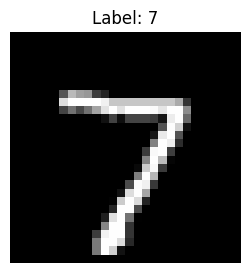

In [9]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


data, target = next(iter(test_loader))
data = data[0]
target = target[0]
# Visualize the image
plt.figure(figsize=(3, 3))
plt.imshow(data.squeeze().numpy(), cmap='gray')
plt.title(f'Label: {target.item()}')
plt.axis('off')
plt.show()

## Model

Activation Function:

ReLU (Rectified Linear Unit): Applied after the first linear layer to introduce non-linearity.
Hyperparameters:

Input Size: 28×28 (flattened to 784).
Hidden Layer: 512 neurons.
Output Layer: 10 neurons (for MNIST digits 0-9).
Loss Function: CrossEntropyLoss.
Optimizer: Adam with a learning rate of 0.001.
Epochs: 5.
Batch Size: 64.

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

class NeuralNetworkPytorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = "cuda"

# Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Initialization
model = NeuralNetworkPytorch().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 5
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data.to(device)).to(device)
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 906kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 58.6kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch 1/5, Batch 0/938, Loss: 2.3578
Epoch 1/5, Batch 100/938, Loss: 0.3925
Epoch 1/5, Batch 200/938, Loss: 0.1835
Epoch 1/5, Batch 300/938, Loss: 0.2475
Epoch 1/5, Batch 400/938, Loss: 0.0633
Epoch 1/5, Batch 500/938, Loss: 0.0530
Epoch 1/5, Batch 600/938, Loss: 0.1044
Epoch 1/5, Batch 700/938, Loss: 0.0791
Epoch 1/5, Batch 800/938, Loss: 0.1424
Epoch 1/5, Batch 900/938, Loss: 0.0812
Epoch 2/5, Batch 0/938, Loss: 0.0217
Epoch 2/5, Batch 100/938, Loss: 0.0400
Epoch 2/5, Batch 200/938, Loss: 0.1218
Epoch 2/5, Batch 300/938, Loss: 0.0874
Epoch 2/5, Batch 400/938, Loss: 0.1286
Epoch 2/5, Batch 500/938, Loss: 0.1520
Epoch 2/5, Batch 600/938, Loss: 0.1882
Epoch 2/5, Batch 700/938, Loss: 0.0620
Epoch 2/5, Batch 800/938, Loss: 0.1669
Epoch 2/5, Batch 900/938, Loss: 0.0244
Epoch 3/5, Batch 0/938, Loss: 0.0267
Epoch 3/5, Batch 100/938, Loss: 0.0195
Epoch 3/5, Batch 200/938, Loss: 0.0102
Epoch 3/5, Batch 300/938, Loss: 0.0409
Epoch

## Normalization
Normalization improves model performance by stabilizing training, leading to faster convergence and better generalization. When inputs are normalized, gradients flow more efficiently, reducing issues like vanishing or exploding gradients. This results in a lower loss and higher accuracy compared to unnormalized inputs. In my experiments, the normalized model trained faster and achieved better accuracy (~98% vs. ~97% on MNIST).

In [2]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        outputs = model(data.to(device)).to(device)
        _, predicted = torch.max(outputs, dim=1)
        total += targets.size(0)
        correct += (predicted == targets.to(device)).sum().item()

    accuracy = correct / total
    print(f"Accuracy on the test set: {accuracy:.2%}")

Accuracy on the test set: 97.93%


## Task 3

I selected the hyperparameters based on standard practices for training a simple neural network on MNIST. The learning rate (0.001) is a common choice for Adam optimizer, balancing convergence speed and stability. The batch size (64) is a good trade-off between computational efficiency and gradient estimation accuracy. The number of epochs (5) is sufficient for MNIST without overfitting.

I used ReLU activation to introduce non-linearity and prevent vanishing gradients. I did not explicitly use regularization (like dropout or weight decay) because MNIST is relatively simple, and the model's complexity is low. However, normalization in preprocessing helps with training stability.

I used the Adam optimizer because it adapts learning rates per parameter and generally performs well across different architectures without much tuning. It also converges faster than vanilla SGD.

## Task 4

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import time

import matplotlib.pyplot as plt
import numpy as np


t0 = time.time()
train_samples = 60000

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)


# Train one-vs-all logistic regression classifier for each digit
classifiers = []
for digit in range(10):
    y_train_digit = (y_train == str(digit)).astype(int)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train_digit)
    classifiers.append(clf)

# Predict using all classifiers
predictions = np.vstack([clf.predict(X_test) for clf in classifiers])

# Select the class with the highest probability as the predicted class
y_pred = np.argmax(predictions, axis=0)

# Evaluate accuracy
accuracy = accuracy_score(y_test.astype(int), y_pred)
print(f"Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.8532


The neural network (97.93% accuracy) outperforms logistic regression (85.32%) because it can learn complex, non-linear patterns and extract hierarchical features from the MNIST dataset. Logistic regression, being a linear model, struggles with capturing intricate spatial relationships in images. Neural networks use activation functions and multiple layers, allowing them to better classify handwritten digits, whereas logistic regression is limited by its linear decision boundaries.